# Arima

In this notebook we perform ARIMA on processed Bixi bike history data.

Required imports:

In [1]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Imports for time series

In [2]:
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
register_matplotlib_converters()
from time import time

<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>
<div style="border-bottom: 3px solid black"></div>

## Loading the Time-Series Data

Load the bixi trip history data and combine it into a single Pandas DataFrame.


In [3]:
station_bike_demand = pd.read_csv('data/mr_bike_demand.csv', index_col='start_date', parse_dates=['start_date']).asfreq('D')
display(station_bike_demand.head())

,trip_count
start_date,
2014-04-15,31
2014-04-16,67
2014-04-17,140
2014-04-18,108
2014-04-19,128


In [4]:
#infer the frequency of the data
station_bike_demand = station_bike_demand.asfreq(pd.infer_freq(station_bike_demand.index))

### Time frame:
Selecting data from 2014 to 2018

In [5]:
start_date = datetime(2014, 1, 1)
end_date = datetime(2019, 12, 31)
lim_station_bike_demand = station_bike_demand[start_date:end_date]
display(lim_station_bike_demand)

,trip_count
start_date,
2014-04-15,31
2014-04-16,67
2014-04-17,140
2014-04-18,108
2014-04-19,128
...,...
2019-10-27,70
2019-10-28,173
2019-10-29,186


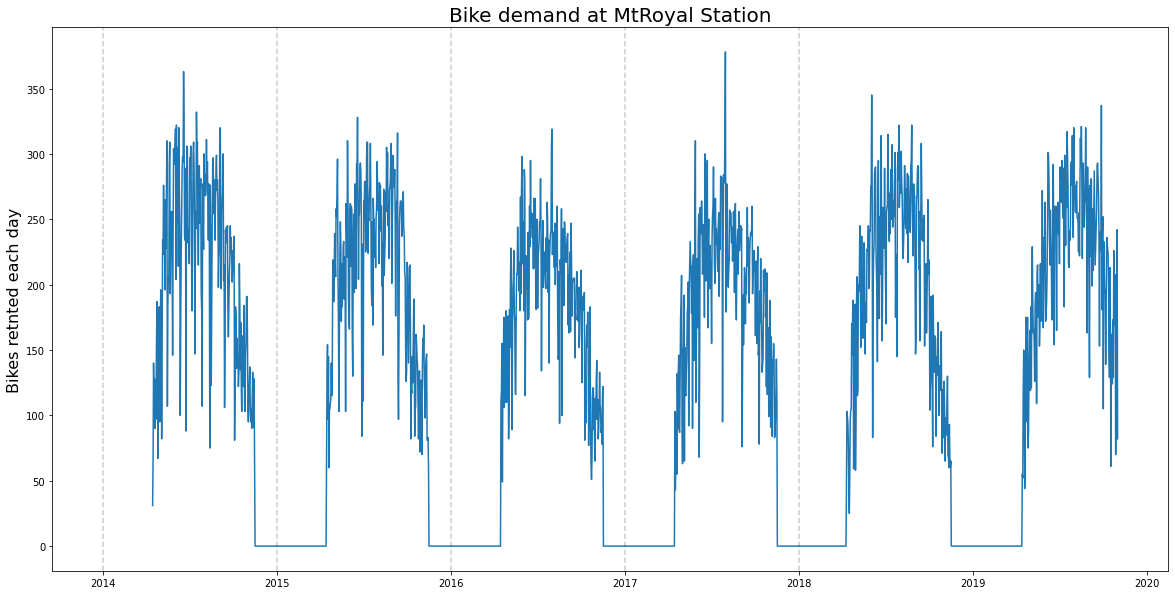

In [6]:
plt.figure(figsize=(20,10))
plt.plot(lim_station_bike_demand)
plt.title('Bike demand at MtRoyal Station', fontsize=20)
plt.ylabel('Bikes retnted each day', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

## Remove the trend

In [7]:
first_diff = lim_station_bike_demand.diff()[1:]

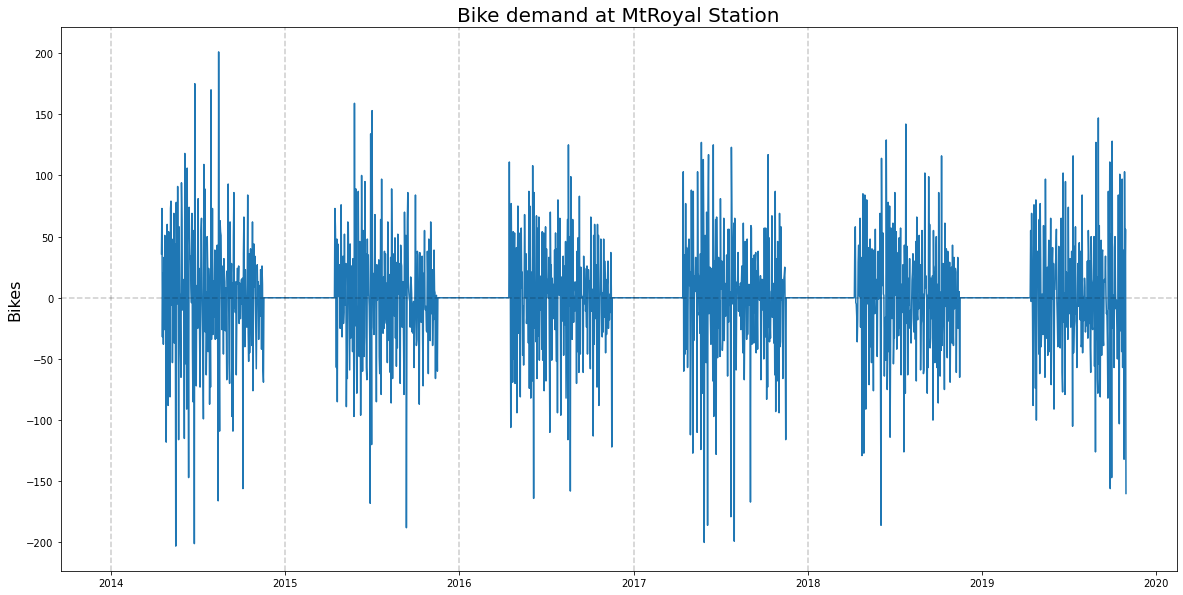

In [8]:
plt.figure(figsize=(20, 10))
plt.plot(first_diff)
plt.title('Bike demand at MtRoyal Station', fontsize=20)
plt.ylabel('Bikes', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
plt.axhline(0, color='k', linestyle='--', alpha=0.2);

## ACF

/Users/hugo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:655: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(


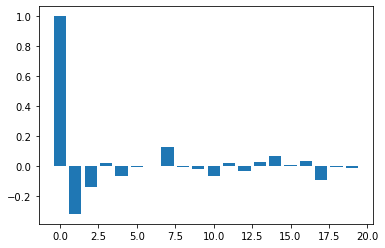

In [9]:
acf_vals = acf(first_diff, fft = False)
num_lags = 20
plt.bar(range(num_lags), acf_vals[:num_lags]);

## PACF

/Users/hugo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1022: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs // 2 - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(


<BarContainer object of 15 artists>

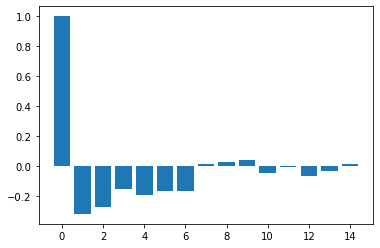

In [10]:
pacf_vals = pacf(first_diff)
num_lags = 15
plt.bar(range(num_lags), pacf_vals[:num_lags])

## Get training and testing sets

In [11]:
train_end = datetime(2018, 11, 15)
test_end = datetime(2019, 12, 31)

train_data = lim_station_bike_demand[:train_end]
test_data = lim_station_bike_demand[train_end + timedelta(days=1):test_end]

## Fit the SARIMA Model -------------------------- NEEDS TO BE FIXED

In [12]:
my_order = (0,1,0) # ---------------------------- PLS FIX
my_seasonal_order = (1, 0, 1, 12) # ------------- PLS FIX

In [13]:
# Defining model
model = SARIMAX(train_data, order = my_order, seasonal_order = my_seasonal_order)

In [14]:
# Fit the model
start = time()
model_fit = model.fit()
end = time()
print('Model Fitting Time:', end - start)

Model Fitting Time: 0.4098849296569824


In [15]:
# Summary of the model
print(model_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                           trip_count   No. Observations:                 1676
Model:             SARIMAX(0, 1, 0)x(1, 0, [1], 12)   Log Likelihood               -8626.998
Date:                              Wed, 24 Nov 2021   AIC                          17259.997
Time:                                      13:44:52   BIC                          17276.268
Sample:                                  04-15-2014   HQIC                         17266.025
                                       - 11-15-2018                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.3795      0.536      0.708      0.479      -0.672       1.431
ma.S.L12      -0.40

### Predictions

In [20]:
# Get predictions and residuals
predictions = model_fit.forecast(len(test_data))
predictions = pd.Series(predictions, index=test_data.index)
display(predictions)

start_date
2018-11-16    64.439394
2018-11-17    64.501376
2018-11-18    64.547940
2018-11-19    63.627371
2018-11-20    64.165552
                ...    
2019-10-27    66.945346
2019-10-28    66.945346
2019-10-29    66.945346
2019-10-30    66.945346
2019-10-31    66.945346
Freq: D, Name: predicted_mean, Length: 350, dtype: float64

### Residuals:

In [21]:
residuals = test_data - predictions
display(residuals)

,2018-11-16 00:00:00,2018-11-17 00:00:00,2018-11-18 00:00:00,2018-11-19 00:00:00,2018-11-20 00:00:00,2018-11-21 00:00:00,2018-11-22 00:00:00,2018-11-23 00:00:00,2018-11-24 00:00:00,2018-11-25 00:00:00,...,2019-10-23 00:00:00,2019-10-24 00:00:00,2019-10-25 00:00:00,2019-10-26 00:00:00,2019-10-27 00:00:00,2019-10-28 00:00:00,2019-10-29 00:00:00,2019-10-30 00:00:00,2019-10-31 00:00:00,trip_count
start_date,,,,,,,,,,,,,,,,,,,,,
2018-11-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-11-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-11-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-11-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-11-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-10-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-10-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Plot prediction:

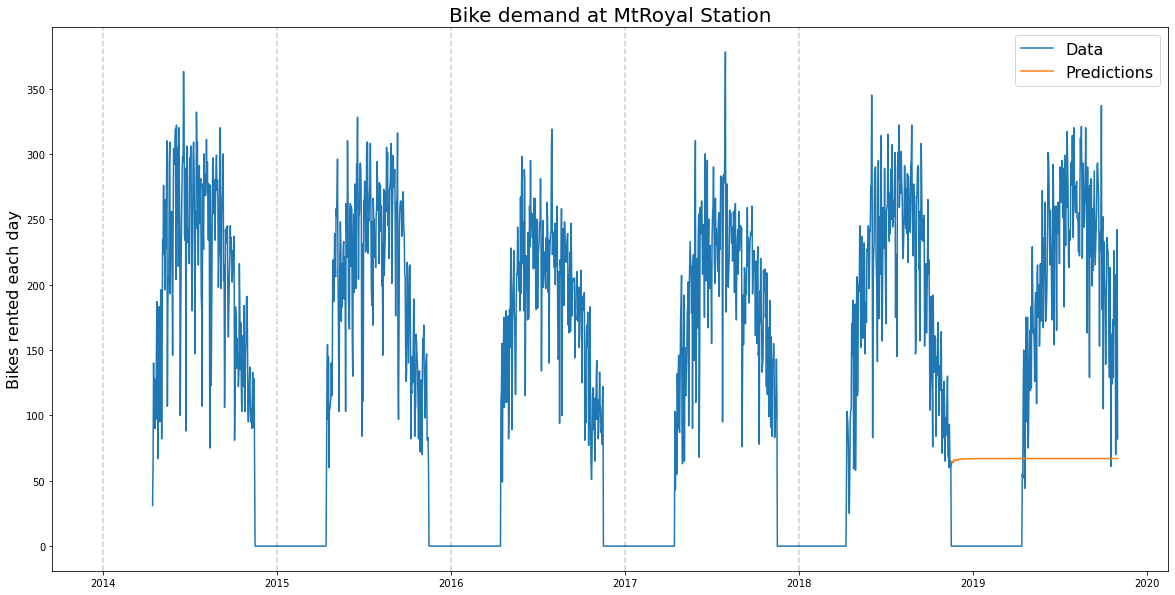

In [17]:
plt.figure(figsize=(20, 10))

plt.plot(lim_station_bike_demand)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Bike demand at MtRoyal Station', fontsize=20)
plt.ylabel('Bikes rented each day', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)